In [1]:
#RUN IN SAGIS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
import scipy.io
from functools import reduce
from pyproj import Proj, transform #can run this from sageo
import rasterio
# import rasterstats
# from netCDF4 import Dataset
import shapely
# import rioxarray
# import xarray
from functools import reduce
import glob
import re
import math
# import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.transforms import Affine2D
from matplotlib.lines import Line2D
from shapely.wkt import loads, dumps
from shapely.ops import polygonize, split
from fiona.crs import from_epsg
import h5py

# from osgeo import ogr
from shapely.geometry import MultiLineString, Point, LineString, Polygon
from shapely import wkt
import sys

pd.set_option('display.max_columns', 200)
shapely.speedups.enable()

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

date_string='GOOD_Spring2022_v6'

# rgi = gpd.read_file('/Users/willkochtitzky/Projects/Arctic_frontal_ablation/vector_files/rgi60_Arctic_glaciers_3995_simple150.gpkg')
rgi = gpd.read_file('/Users/willkochtitzky/Projects/Greenland_Calving/RGI_arctic_for_Greenland_plotting.gpkg')
# rgi['geometry'] = rgi.buffer(0)
# rgi = rgi[rgi.centroid.y>50].to_crs(epsg=3995)
# rgi_tidewater = gpd.read_file('/Users/willkochtitzky/Projects/Arctic_frontal_ablation/Terminus_positions/RGI_Arctic_marine_terminating_glacier_outlines.gpkg') 
# Greenland_IS = gpd.read_file('/Users/willkochtitzky/data/Greenland_Ice_Sheet.gpkg')
Greenland_IS = gpd.read_file('/Users/willkochtitzky/Projects/Greenland_Calving/Mouginot_GIS_basins/Kochtitzky_edits_Mouginot_GIS_basins_3995_v2.gpkg')
# regions_outlines = gpd.read_file('/Users/willkochtitzky/Projects/Arctic_frontal_ablation/vector_files/plotting_regions2.gpkg')

In [2]:
Arctic_discharge_fluxes_with_area_export = gpd.read_file('Greenland/Greenland_frontal_ablation_'+date_string+'.gpkg', driver="GPKG")

In [4]:
Arctic_discharge_fluxes_with_area_export#.sum()[150:]

,name,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,bed_machine_min,bed_machine_max,do_we_have_an_observation_in_middle_fifth,easting,northing,bed_machine_mean,bed_machine_err,best_thickness,best_thickness_early_mean,best_thickness_late_mean,thickness_mean_uncertainty,length_early_avg,length_early_avg_err,length_late_avg,length_late_avg_err,2000_2010_mean,2000_2010_mean_err,2010_2018_mean,2010_2018_mean_err,GlaThiDa_observations,num_pts,gate_length_km,best_thickness_early,best_thickness_early_err,best_thickness_late,best_thickness_late_err,Glacier_type_x,area_km2_gained_total,perimeter_gained_total,perimeter_error_gained_total,Glacier_type_y,area_km2_lost_total,perimeter_lost_total,perimeter_error_lost_total,Glacier_type_x.1,area_km2_lost_early,perimeter_lost_early,perimeter_error_lost_early,Glacier_type_y.1,area_km2_gained_early,perimeter_gained_early,perimeter_error_gained_early,Glacier_type_x.2,area_km2_lost_late,perimeter_lost_late,perimeter_error_lost_late,Glacier_type_y.2,area_km2_gained_late,perimeter_gained_late,perimeter_error_gained_late,Early_satellite_id,Middle_satellite_id,Late_satellite_id,Early_date,Mid_date,Late_date,Early_date_decimal_year,Middle_date_decimal_year,Late_date_decimal_year,total_years_elapsed,early_to_middle_years_elapsed,middle_to_late_years_elapsed,net_area_change_total,net_area_change_total_error,net_area_change_per_year_total,net_area_change_per_year_total_error,net_area_change_early,net_area_change_early_error,net_area_change_per_year_early,net_area_change_per_year_early_error,net_area_change_late,net_area_change_late_error,net_area_change_per_year_late,net_area_change_per_year_late_error,average_OIB_thickness_lost_early,average_OIB_thickness_gained_early,average_OIB_thickness_lost_late,average_OIB_thickness_gained_late,average_OIB_thickness_lost_total,average_OIB_thickness_gained_total,average_bedmachine_thickness_lost_early,average_bedmachine_thickness_gained_early,average_bedmachine_thickness_lost_late,average_bedmachine_thickness_gained_late,average_bedmachine_thickness_lost_total,average_bedmachine_thickness_gained_total,average_bedmachine_thickness_lost_early_err,average_bedmachine_thickness_gained_early_err,average_bedmachine_thickness_lost_late_err,average_bedmachine_thickness_gained_late_err,average_bedmachine_thickness_lost_total_err,average_bedmachine_thickness_gained_total_err,average_Milan_thickness_lost_early,average_Milan_thickness_gained_early,average_Milan_thickness_lost_late,...,lon,early_poly_early_melt_err,middle_poly_early_melt_err,middle_poly_late_melt_err,late_poly_late_melt_err,terminus_melt_early,terminus_melt_late,terminus_melt_early_err,terminus_melt_late_err,terminus_melt_total,terminus_melt_total_err,average_Milan_thickness_lost_early_debiased,average_Milan_thickness_gained_early_debiased,average_bedmachine_thickness_gained_early_debiased,average_Milan_thickness_lost_late_debiased,average_Milan_thickness_gained_late_debiased,average_Milan_thickness_lost_total_debiased,average_Milan_thickness_gained_total_debiased,thickness_for_area_lost_early_source,thickness_for_area_gained_early_source,thickness_for_area_lost_late_source,thickness_for_area_gained_late_source,thickness_for_area_lost_early,thickness_for_area_lost_early_err,thickness_for_area_gained_early,thickness_for_area_gained_early_err,thickness_for_area_lost_late,thickness_for_area_lost_late_err,thickness_for_area_gained_late,thickness_for_area_gained_late_err,thickness_for_area_lost_total,thickness_for_area_lost_total_err,thickness_for_area_gained_total,thickness_for_area_gained_total_err,Glacier_type,region,thickness_for_area_lost_early_err_fullycorr,thickness_for_area_gained_early_err_fullycorr,thickness_for_area_lost_late_err_fullycorr,thickness_for_area_gained_late_err_fullycorr,thickness_for_area_lost_total_err_fullycorr,thickness_for_area_gained_total_err_fullycorr,Greenland_region_name,area_flux_gt_gained_early,area_flux_gt_gained_early_error,area

In [5]:
frontal_ablation_export = Arctic_discharge_fluxes_with_area_export[['name','lon', 'lat','gate_length_km',
        'do_we_have_an_observation_in_middle_fifth',                                                             
        'GlaThiDa_observations',
        '2000_2010_mean', '2000_2010_mean_err', '2010_2018_mean','2010_2018_mean_err',  
        'best_thickness_early', 'best_thickness_early_err','best_thickness_late', 'best_thickness_late_err',
        'Early_satellite_id','Middle_satellite_id', 'Late_satellite_id','FA_not_calculated_in_normal_way_early','FA_not_calculated_in_normal_way_late',
        'net_area_change_per_year_early','net_area_change_per_year_early_error', 'net_area_change_per_year_late','net_area_change_per_year_late_error',
        'melt_correct_gt_early_terminus_change','melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
        'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
        'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error',
        'terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
        '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt', '2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt',
        'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err',
        'Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err','geometry']]

frontal_ablation_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'] = np.abs(frontal_ablation_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'])
frontal_ablation_export['Frontal_ablation_2010_to_2020_gt_per_yr_mean'] = np.abs(frontal_ablation_export['Frontal_ablation_2010_to_2020_gt_per_yr_mean'])

frontal_ablation_export = frontal_ablation_export.rename(columns={'2000_2010_mean':'2000_2010_mean_velocity',
                            '2000_2010_mean_err':'2000_2010_mean_velocity_error', '2010_2018_mean':'2010_2020_mean_velocity','2010_2018_mean_err':'2010_2020_mean_velocity_error',
                            '2000_2010_mean_flux_gt':'2000_2010_mean_discharge_gt_per_year','2000_2010_mean_err_gt':'2000_2010_mean_discharge_err_gt_per_year', '2010_2020_mean_flux_gt':'2010_2020_mean_discharge_gt_per_year','2010_2018_mean_err_gt':'2010_2018_mean_discharge_err_gt_per_year', 
                            'net_area_change_per_year_early':'net_area_change_km2_per_year_early','net_area_change_per_year_early_error':'net_area_change_km2_per_year_early_error',
                            'net_area_change_per_year_late':'net_area_change_km2_per_year_late','net_area_change_per_year_late_error':'net_area_change_km2_per_year_late_error',
#                             'Frontal_ablation_2000_to_2010_gt_per_yr_mean':'Solid_ice_flux_2000_too_2010_gt_per_year_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err':'Solid_ice_flux_2000_too_2010_gt_per_year_mean_error',
#                             'Frontal_ablation_2010_to_2020_gt_per_yr_mean':'Solid_ice_flux_2010_too_2020_gt_per_year_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err':'Solid_ice_flux_2010_too_2020_gt_per_year_mean_error',
                                 })

frontal_ablation_export.set_crs(epsg=3995, inplace=True,allow_override=True)
frontal_ablation_export.to_file('Greenland_frontal_ablation_Kochtitzky_et_al_v2.geojson', driver='GeoJSON')
frontal_ablation_export.to_csv('Greenland_frontal_ablation_Kochtitzky_et_al_v2.csv')

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [6]:
#add in Mankoff glaciers and data

#read in Mankoff discharge estiamtes to compare differences
Mankoff_names = pd.read_csv('/Users/willkochtitzky/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Files/Grad_school/Research/Sources/Arctic_Glaciers/greenland/dataverse_files/gate_meta.csv')
Mankoff_discharge = pd.read_csv('/Users/willkochtitzky/Library/Mobile Documents/com~apple~CloudDocs/Desktop/Files/Grad_school/Research/Sources/Arctic_Glaciers/greenland/dataverse_files/gate_D_2010_2020.csv')

Mankoff_discharge = Mankoff_discharge.transpose().drop(['Date']).astype('float')
Mankoff_discharge['2010_2020_mean_discharge_Mankoff']=Mankoff_discharge.mean(axis=1)
Mankoff_discharge = Mankoff_discharge['2010_2020_mean_discharge_Mankoff'].reset_index().rename(columns={'index':'glacier_id'})
Mankoff_discharge['glacier_id']=Mankoff_discharge['glacier_id'].astype(str).astype(int)
Mankoff_discharge=pd.merge(Mankoff_names,Mankoff_discharge,left_on='gate',right_on='glacier_id').groupby('Mouginot_2019').sum()['2010_2020_mean_discharge_Mankoff'].reset_index()

Arctic_discharge_fluxes_with_area_export_with_Mankoff = pd.merge(Arctic_discharge_fluxes_with_area_export,Mankoff_discharge,how='left',left_on='name',right_on='Mouginot_2019')#[['name','best_thickness_mean','2010_2018_mean','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge','2010_2020_mean_discharge_Mankoff','geometry']]
Arctic_discharge_fluxes_with_area_export_with_Mankoff.loc[Arctic_discharge_fluxes_with_area_export_with_Mankoff['2010_2020_mean_discharge_Mankoff']>0,'included_in_Mankoff']=1
Arctic_discharge_fluxes_with_area_export_with_Mankoff['included_in_Mankoff'].fillna(0,inplace=True)



In [7]:
Arctic_discharge_fluxes_with_area_export_with_Mankoff.groupby('included_in_Mankoff').sum()[[
    '2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt',
    'Frontal_ablation_2010_to_2020_gt_per_yr_mean_without_melt','Frontal_ablation_2010_to_2020_gt_per_yr_mean_without_melt_err',
#     'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err',
    'Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err','2010_2020_mean_discharge_Mankoff']]

,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,Frontal_ablation_2010_to_2020_gt_per_yr_mean_without_melt,Frontal_ablation_2010_to_2020_gt_per_yr_mean_without_melt_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err,2010_2020_mean_discharge_Mankoff
included_in_Mankoff,,,,,,,
0.0,29.481096,1.618029,38.595767,2.030363,37.218605,2.125951,0.000000
1.0,395.283426,5.399287,440.986143,8.097169,428.876903,8.877000,457.591985


In [8]:
# add data from Michaela King
king_discharge = gpd.read_file('/Users/willkochtitzky/Projects/Greenland_Calving/King_data/GrIS_D_1985-2018_edited.gpkg', driver="GPKG")
king_discharge_with_attributes = gpd.sjoin(king_discharge,Greenland_IS,how='left')
king_discharge_with_attributes.to_file('/Users/willkochtitzky/Projects/Greenland_Calving/King_data/GrIS_D_1985-2018_edited_with_mouginot.gpkg', driver="GPKG")

In [9]:
king_discharge_with_attributes = king_discharge_with_attributes.groupby('NAME').sum()

Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King = pd.merge(Arctic_discharge_fluxes_with_area_export_with_Mankoff,king_discharge_with_attributes,how='left',left_on='name',right_on='NAME')#[['name','best_thickness_mean','2010_2018_mean','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge','2010_2020_mean_discharge_Mankoff','geometry']]
Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['included_in_King']=0
Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King.loc[Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_discharge']>0,'included_in_King']=1

Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['Kochtitzky_minus_Mankoff'] = Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_mean_flux_gt']-Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_mean_discharge_Mankoff']
Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['Kochtitzky_minus_King'] = Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_mean_flux_gt']-Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_discharge']
Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['Mankoff_minus_King'] = Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_mean_discharge_Mankoff']-Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King['2010_2020_discharge']

Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King=Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King[['name','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt',
                                    '2010_2020_mean_discharge_Mankoff','2010_2020_discharge','2000_2010_discharge_err','Kochtitzky_minus_Mankoff','Kochtitzky_minus_King','Mankoff_minus_King',
                                    'best_thickness_late_mean', 'thickness_mean_uncertainty', '2010_2018_mean', '2010_2018_mean_err','gate_length_km','included_in_King','geometry']]
Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King.rename(columns={'2010_2020_mean_flux_gt':'Kochtitzky_discharge','2010_2020_mean_flux_err_gt':'Kochtitzky_discharge_error',
                                                                               '2010_2020_mean_discharge_Mankoff':'Mankoff_discharge','2010_2020_discharge':'King_discharge','2000_2010_discharge_err':'King_discharge_error',
                                                                               'best_thickness_late_mean':'Kochtitzky_thickness_late_mean', 'thickness_mean_uncertainty':'Kochtitzky_thickness_mean_error', '2010_2018_mean':'Kochtitzky_velocity_mean', '2010_2018_mean_err':'Kochtitzky_velocity_mean_error','gate_length_km':'Kochtitzky_flux_gate_length'},inplace=True)

Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King.to_file('/Users/willkochtitzky/Projects/Greenland_Calving/King_data/Kochtitzky_Mankoff_King_comparison.gpkg', driver="GPKG")

In [10]:
Arctic_discharge_fluxes_with_area_export_with_Mankoff_and_King.groupby('included_in_King').sum()

,Kochtitzky_discharge,Kochtitzky_discharge_error,Mankoff_discharge,King_discharge,King_discharge_error,Kochtitzky_minus_Mankoff,Kochtitzky_minus_King,Mankoff_minus_King,Kochtitzky_thickness_late_mean,Kochtitzky_thickness_mean_error,Kochtitzky_velocity_mean,Kochtitzky_velocity_mean_error,Kochtitzky_flux_gate_length
included_in_King,,,,,,,,,,,,,
0,10.688751,1.205457,8.514899,0.000000,0.000000,-1.964395,0.00000,0.000000,19574.246674,18441.903169,22137.116294,6168.080861,1083.275
1,414.075771,5.811859,449.077086,487.215851,101.018194,-60.344163,-73.14008,-12.682826,38099.829569,5572.495171,109007.756581,3271.381204,1970.100


In [349]:
GRE_GIC_fa = Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Glacier_type']=='mountain']
date_string2='Fall2021_v10'
GIC_fa = gpd.read_file('Arctic_discharge_fluxes_with_area_epsg3995_'+date_string2+'_V4.gpkg', driver="GPKG")#change file name based on distance
GIC_fa = GIC_fa[GIC_fa['Region_name']=='Greenland']

In [367]:
GRE_combined_fa = GIC_fa.merge(GRE_GIC_fa,left_on='RGIId',right_on='name')
GRE_combined_fa.loc[:,'thickness_difference']=GRE_combined_fa['best_thickness_mean_x']-GRE_combined_fa['best_thickness_mean_y']

GRE_combined_fa_export=GRE_combined_fa[['Frontal_ablation_2010_to_2020_gt_per_yr_mean_x','Frontal_ablation_2010_to_2020_gt_per_yr_mean_y',
                                        'terminus_gt_change_per_year_late_x','terminus_gt_change_per_year_late_y',
#                                         'terminus_gt_change_per_year_late_without_melt_x','terminus_gt_change_per_year_late_without_melt_y',#'melt_correct_gt_late_terminus_change_x','melt_correct_gt_late_terminus_change_y'
#                                         'area_flux_gt_lost_late_x','area_flux_gt_lost_late_y',
#                                         'area_km2_lost_late_x','area_km2_lost_late_y','thickness_for_area_lost_late_x','thickness_for_area_lost_late_y',
#                                         'average_bedmachine_thickness_lost_late',
#                                         'best_thickness_mean_x','best_thickness_mean_y',
#                                         '2010_2018_mean_x','2010_2018_mean_y','area_below_fluxgate_late_x','area_below_fluxgate_late_y','Melt_late_avg','late_poly_late_melt',
#                                         'melt_correct_gt_late_discharge_x','melt_correct_gt_late_discharge_y','melt_correct_gt_late_terminus_change_x','melt_correct_gt_late_terminus_change_y',
#                                         '2010_2020_mean_flux_gt_x','2010_2020_mean_flux_gt_y','terminus_gt_change_per_year_late_x','terminus_gt_change_per_year_late_y','thickness_difference'
                                        'geometry_x']]

GRE_combined_fa_export.loc[:,'terminus_gt_change_per_year_late_difference']=GRE_combined_fa_export['terminus_gt_change_per_year_late_x']-GRE_combined_fa_export['terminus_gt_change_per_year_late_y']
GRE_combined_fa_export.loc[:,'geometry']=GRE_combined_fa_export['geometry_x']
GRE_combined_fa_export.drop(columns='geometry_x',inplace=True)

GRE_combined_fa_export=gpd.GeoDataFrame(GRE_combined_fa_export,geometry=GRE_combined_fa_export['geometry'])
GRE_combined_fa_export.to_file('Greenland/Greenland_frontal_ablation_comparison_with_GIC_data_'+date_string+'.gpkg', driver="GPKG")

In [351]:
GRE_combined_fa

,RGIId,2000_2010_mean_flux_gt_x,2000_2010_mean_flux_err_gt_x,2010_2020_mean_flux_gt_x,2010_2020_mean_flux_err_gt_x,Name_x,Area,Zmin,Zmax,Zmed,Slope,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Milan_thickness_min,region,Milan_thickness_max,do_we_have_an_observation_in_middle_fifth_x,easting_x,northing_x,Milan_thickness_mean,0000_v,best_thickness_mean_x,thickness_mean_uncertainty_x,length_early_avg_x,length_early_avg_err_x,length_late_avg_x,length_late_avg_err_x,2000_2010_mean_x,2000_2010_mean_err_x,2000_2010_mean_count,2010_2018_mean_x,2010_2018_mean_err_x,2010_2018_mean_count,best_thickness_early,best_thickness_early_err,best_thickness_late,best_thickness_late_err,number_velocity_obs_early,number_velocity_obs_late,num_pts_x,GlaThiDa_observations_x,Tomography_observations,Russian_observations,gate_length_km_x,RGIid_2_1,area_below_fluxgate_early_x,area_below_fluxgate_middle_x,area_below_fluxgate_late_x,average_distance_from_fluxgate_to_terminus_early,average_distance_from_fluxgate_to_terminus_middle,average_distance_from_fluxgate_to_terminus_late,RGIid_original,RGIId_y,Melt_early_avg,Melt_late_avg,Melt_early_avg_err,Melt_late_avg_err,Melt_fluxes_from_regional_estimate,Melt_total_avg,Melt_total_avg_err,level_0_x,index_x,area_km2_gained_total_x,perimeter_gained_total_x,perimeter_error_gained_total_x,area_km2_lost_total_x,perimeter_lost_total_x,perimeter_error_lost_total_x,area_km2_lost_early_x,perimeter_lost_early_x,perimeter_error_lost_early_x,area_km2_gained_early_x,perimeter_gained_early_x,perimeter_error_gained_early_x,area_km2_lost_late_x,perimeter_lost_late_x,perimeter_error_lost_late_x,area_km2_gained_late_x,perimeter_gained_late_x,perimeter_error_gained_late_x,Early_satellite_id_x,Middle_satellite_id_x,Late_satellite_id_x,Early_date_x,Mid_date_x,Late_date_x,Early_date_decimal_year_x,Middle_date_decimal_year_x,Late_date_decimal_year_x,total_years_elapsed_x,early_to_middle_years_elapsed_x,middle_to_late_years_elapsed_x,net_area_change_total_x,net_area_change_total_error_x,...,average_bedmachine_thickness_lost_late,average_bedmachine_thickness_gained_late,average_bedmachine_thickness_lost_total,average_bedmachine_thickness_gained_total,average_bedmachine_thickness_lost_early_err,average_bedmachine_thickness_gained_early_err,average_bedmachine_thickness_lost_late_err,average_bedmachine_thickness_gained_late_err,average_bedmachine_thickness_lost_total_err,average_bedmachine_thickness_gained_total_err,early_poly_early_melt,area_below_fluxgate_early_y,middle_poly_early_melt,middle_poly_late_melt,area_below_fluxgate_middle_y,late_poly_late_melt,area_below_fluxgate_late_y,lat_y,lon_y,early_poly_early_melt_err,middle_poly_early_melt_err,middle_poly_late_melt_err,late_poly_late_melt_err,terminus_melt_early,terminus_melt_late,terminus_melt_early_err,terminus_melt_late_err,terminus_melt_total,terminus_melt_total_err,thickness_for_area_lost_early_y,thickness_for_area_lost_early_err_y,thickness_for_area_gained_early_y,thickness_for_area_gained_early_err_y,thickness_for_area_lost_late_y,thickness_for_area_lost_late_err_y,thickness_for_area_gained_late_y,thickness_for_area_gained_late_err_y,thickness_for_area_lost_total_y,thickness_for_area_lost_total_err_y,thickness_for_area_gained_total_y,thickness_for_area_gained_total_err_y,area_flux_gt_gained_early_y,area_flux_gt_gained_early_error_y,area_flux_gt_lost_early_y,area_flux_gt_lost_early_error_y,area_flux_gt_gained_late_y,area_flux_gt_gained_late_error_y,area_flux_gt_lost_late_y,area_flux_gt_lost_late_error_y,area_flux_gt_gained_total_y,area_flux_gt_gained_total_error_y,area_flux_gt_lost_total_y,area_flux_gt_lost_total_error_y,terminus_gt_change_per_year_early_without_melt_y,terminus_gt_change_per_year_early_area_error_without_melt_y,terminus_gt_change_per_year_late_without_melt_y,terminus_gt_change_per_year_late_area_error_without_melt_y,terminus_gt_change_per_year_total_without_melt_y,terminus_gt_change_per_year_total_area_error_without_melt_y,2000_2010_mean_flux_gt_without

In [6]:
Arctic_discharge_fluxes_with_area_export

,name,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,bed_machine_min,bed_machine_max,do_we_have_an_observation_in_middle_fifth,easting,northing,bed_machine_mean,bed_machine_err,best_thickness_mean,thickness_mean_uncertainty,length_early_avg,length_early_avg_err,length_late_avg,length_late_avg_err,2000_2010_mean,2000_2010_mean_err,2010_2018_mean,2010_2018_mean_err,GlaThiDa_observations,num_pts,gate_length_km,level_0,index,area_km2_gained_total,perimeter_gained_total,perimeter_error_gained_total,area_km2_lost_total,perimeter_lost_total,perimeter_error_lost_total,area_km2_lost_early,perimeter_lost_early,perimeter_error_lost_early,area_km2_gained_early,perimeter_gained_early,perimeter_error_gained_early,area_km2_lost_late,perimeter_lost_late,perimeter_error_lost_late,area_km2_gained_late,perimeter_gained_late,perimeter_error_gained_late,Early_satellite_id,Middle_satellite_id,Late_satellite_id,Early_date,Mid_date,Late_date,Early_date_decimal_year,Middle_date_decimal_year,Late_date_decimal_year,total_years_elapsed,early_to_middle_years_elapsed,middle_to_late_years_elapsed,net_area_change_total,net_area_change_total_error,net_area_change_per_year_total,net_area_change_per_year_total_error,net_area_change_early,net_area_change_early_error,net_area_change_per_year_early,net_area_change_per_year_early_error,net_area_change_late,net_area_change_late_error,net_area_change_per_year_late,net_area_change_per_year_late_error,average_OIB_thickness_lost_early,average_OIB_thickness_gained_early,average_OIB_thickness_lost_late,average_OIB_thickness_gained_late,average_OIB_thickness_lost_total,average_OIB_thickness_gained_total,average_bedmachine_thickness_lost_early,average_bedmachine_thickness_gained_early,average_bedmachine_thickness_lost_late,average_bedmachine_thickness_gained_late,average_bedmachine_thickness_lost_total,average_bedmachine_thickness_gained_total,average_bedmachine_thickness_lost_early_err,average_bedmachine_thickness_gained_early_err,average_bedmachine_thickness_lost_late_err,average_bedmachine_thickness_gained_late_err,average_bedmachine_thickness_lost_total_err,average_bedmachine_thickness_gained_total_err,average_Milan_thickness_lost_early,average_Milan_thickness_gained_early,average_Milan_thickness_lost_late,average_Milan_thickness_gained_late,average_Milan_thickness_lost_early_err,average_Milan_thickness_gained_early_err,average_Milan_thickness_lost_late_err,average_Milan_thickness_gained_late_err,average_Milan_thickness_lost_total,average_Milan_thickness_gained_total,average_Milan_thickness_lost_total_err,average_Milan_thickness_gained_total_err,early_poly_early_melt,area_below_fluxgate_early,middle_poly_early_melt,middle_poly_late_melt,area_below_fluxgate_middle,late_poly_late_melt,area_below_fluxgate_late,lat,lon,early_poly_early_melt_err,middle_poly_early_melt_err,middle_poly_late_melt_err,late_poly_late_melt_err,terminus_melt_early,terminus_melt_late,terminus_melt_early_err,terminus_melt_late_err,terminus_melt_total,terminus_melt_total_err,thickness_for_area_lost_early,thickness_for_area_lost_early_err,thickness_for_area_gained_early,thickness_for_area_gained_early_err,thickness_for_area_lost_late,thickness_for_area_lost_late_err,thickness_for_area_gained_late,thickness_for_area_gained_late_err,thickness_for_area_lost_total,thickness_for_area_lost_total_err,thickness_for_area_gained_total,thickness_for_area_gained_total_err,area_flux_gt_gained_early,area_flux_gt_gained_early_error,area_flux_gt_lost_early,area_flux_gt_lost_early_error,area_flux_gt_gained_late,area_flux_gt_gained_late_error,area_flux_gt_lost_late,area_flux_gt_lost_late_error,area_flux_gt_gained_total,area_flux_gt_gained_total_error,area_flux_gt_lost_total,area_flux_gt_lost_total_error,terminus_gt_change_per_year_early_without_melt,terminus_gt_change_per_year_early_area_error_without_melt,terminus_gt_change_per_year_late_without_melt,terminus_gt_change_per_year_late_area_error_without_melt,terminus_g

In [ ]:
#RESULTS

In [11]:
Arctic_discharge_fluxes_with_area_export.groupby('Glacier_type').count()

,name,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,bed_machine_min,bed_machine_max,do_we_have_an_observation_in_middle_fifth,easting,northing,bed_machine_mean,bed_machine_err,best_thickness,best_thickness_early_mean,best_thickness_late_mean,thickness_mean_uncertainty,length_early_avg,length_early_avg_err,length_late_avg,length_late_avg_err,2000_2010_mean,2000_2010_mean_err,2010_2018_mean,2010_2018_mean_err,GlaThiDa_observations,num_pts,gate_length_km,best_thickness_early,best_thickness_early_err,best_thickness_late,best_thickness_late_err,Glacier_type_x,area_km2_gained_total,perimeter_gained_total,perimeter_error_gained_total,Glacier_type_y,area_km2_lost_total,perimeter_lost_total,perimeter_error_lost_total,Glacier_type_x.1,area_km2_lost_early,perimeter_lost_early,perimeter_error_lost_early,Glacier_type_y.1,area_km2_gained_early,perimeter_gained_early,perimeter_error_gained_early,Glacier_type_x.2,area_km2_lost_late,perimeter_lost_late,perimeter_error_lost_late,Glacier_type_y.2,area_km2_gained_late,perimeter_gained_late,perimeter_error_gained_late,Early_satellite_id,Middle_satellite_id,Late_satellite_id,Early_date,Mid_date,Late_date,Early_date_decimal_year,Middle_date_decimal_year,Late_date_decimal_year,total_years_elapsed,early_to_middle_years_elapsed,middle_to_late_years_elapsed,net_area_change_total,net_area_change_total_error,net_area_change_per_year_total,net_area_change_per_year_total_error,net_area_change_early,net_area_change_early_error,net_area_change_per_year_early,net_area_change_per_year_early_error,net_area_change_late,net_area_change_late_error,net_area_change_per_year_late,net_area_change_per_year_late_error,average_OIB_thickness_lost_early,average_OIB_thickness_gained_early,average_OIB_thickness_lost_late,average_OIB_thickness_gained_late,average_OIB_thickness_lost_total,average_OIB_thickness_gained_total,average_bedmachine_thickness_lost_early,average_bedmachine_thickness_gained_early,average_bedmachine_thickness_lost_late,average_bedmachine_thickness_gained_late,average_bedmachine_thickness_lost_total,average_bedmachine_thickness_gained_total,average_bedmachine_thickness_lost_early_err,average_bedmachine_thickness_gained_early_err,average_bedmachine_thickness_lost_late_err,average_bedmachine_thickness_gained_late_err,average_bedmachine_thickness_lost_total_err,average_bedmachine_thickness_gained_total_err,average_Milan_thickness_lost_early,average_Milan_thickness_gained_early,average_Milan_thickness_lost_late,...,lat,lon,early_poly_early_melt_err,middle_poly_early_melt_err,middle_poly_late_melt_err,late_poly_late_melt_err,terminus_melt_early,terminus_melt_late,terminus_melt_early_err,terminus_melt_late_err,terminus_melt_total,terminus_melt_total_err,average_Milan_thickness_lost_early_debiased,average_Milan_thickness_gained_early_debiased,average_bedmachine_thickness_gained_early_debiased,average_Milan_thickness_lost_late_debiased,average_Milan_thickness_gained_late_debiased,average_Milan_thickness_lost_total_debiased,average_Milan_thickness_gained_total_debiased,thickness_for_area_lost_early_source,thickness_for_area_gained_early_source,thickness_for_area_lost_late_source,thickness_for_area_gained_late_source,thickness_for_area_lost_early,thickness_for_area_lost_early_err,thickness_for_area_gained_early,thickness_for_area_gained_early_err,thickness_for_area_lost_late,thickness_for_area_lost_late_err,thickness_for_area_gained_late,thickness_for_area_gained_late_err,thickness_for_area_lost_total,thickness_for_area_lost_total_err,thickness_for_area_gained_total,thickness_for_area_gained_total_err,region,thickness_for_area_lost_early_err_fullycorr,thickness_for_area_gained_early_err_fullycorr,thickness_for_area_lost_late_err_fullycorr,thickness_for_area_gained_late_err_fullycorr,thickness_for_area_lost_total_err_fullycorr,thickness_for_area_gained_total_err_fullycorr,Greenland_region_name,area_flux_gt_gained_early,area_flux_gt_gained_early_error,area_flux_gt_

In [29]:
Arctic_discharge_fluxes_with_area_export.sum()[['2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err']]

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


2000_2010_mean_flux_gt                              400.114614
2000_2010_mean_flux_err_gt                            9.364888
terminus_gt_change_per_year_early                   -46.538236
terminus_gt_change_per_year_early_area_error          6.697728
Frontal_ablation_2000_to_2010_gt_per_yr_mean        446.643166
Frontal_ablation_2000_to_2010_gt_per_yr_mean_err     12.920518
dtype: object

In [26]:
Arctic_discharge_fluxes_with_area_export.sum()[['2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']]

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


2010_2020_mean_flux_gt                              432.985718
2010_2020_mean_flux_err_gt                              7.1004
terminus_gt_change_per_year_late                    -39.288475
terminus_gt_change_per_year_late_area_error           5.104328
Frontal_ablation_2010_to_2020_gt_per_yr_mean        472.271866
Frontal_ablation_2010_to_2020_gt_per_yr_mean_err      9.970949
dtype: object

In [12]:
#percentage from peripherial glaciers 
print('percentage early',Arctic_discharge_fluxes_with_area_export.groupby('Glacier_type').sum()['Frontal_ablation_2000_to_2010_gt_per_yr_mean'][1]/Arctic_discharge_fluxes_with_area_export.sum()['Frontal_ablation_2000_to_2010_gt_per_yr_mean']*100)
print('percentage late',Arctic_discharge_fluxes_with_area_export.groupby('Glacier_type').sum()['Frontal_ablation_2010_to_2020_gt_per_yr_mean'][1]/Arctic_discharge_fluxes_with_area_export.sum()['Frontal_ablation_2010_to_2020_gt_per_yr_mean']*100)

percentage early 1.207578453891025
percentage late 0.6471942636002603


/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
#portions of discharge and terminus change

print('percentage discharge early',Arctic_discharge_fluxes_with_area_export.sum()['2000_2010_mean_flux_gt']/Arctic_discharge_fluxes_with_area_export.sum()['Frontal_ablation_2000_to_2010_gt_per_yr_mean']*100)
print('percentage discharge late',Arctic_discharge_fluxes_with_area_export.sum()['2010_2020_mean_flux_gt']/Arctic_discharge_fluxes_with_area_export.sum()['Frontal_ablation_2010_to_2020_gt_per_yr_mean']*100)

print('percentage terminus early',Arctic_discharge_fluxes_with_area_export.sum()['terminus_gt_change_per_year_early']/Arctic_discharge_fluxes_with_area_export.sum()['Frontal_ablation_2000_to_2010_gt_per_yr_mean']*-100)
print('percentage terminus late',Arctic_discharge_fluxes_with_area_export.sum()['terminus_gt_change_per_year_late']/Arctic_discharge_fluxes_with_area_export.sum()['Frontal_ablation_2010_to_2020_gt_per_yr_mean']*-100)



percentage discharge early 89.4833062246218
percentage discharge late 91.13250720786029
percentage terminus early 10.518849213019513
percentage terminus late 8.867981516625383


/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.
/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeErr

In [40]:
Arctic_discharge_fluxes_with_area_export.groupby('Glacier_type').sum()[['terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt',#'melt_correct_gt_early_terminus_change', 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']]

,terminus_gt_change_per_year_early,terminus_gt_change_per_year_early_area_error,terminus_gt_change_per_year_late,terminus_gt_change_per_year_late_area_error,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err
Glacier_type,,,,,,,,,,,,
ice sheet,-43.840481,5.730701,-38.746436,4.531422,397.469274,7.873585,431.038106,6.249179,441.305992,10.936231,469.784542,8.839953
mountain,-2.697755,0.967027,-0.542039,0.572906,2.645340,1.491303,1.947612,0.851221,5.337174,1.984287,2.487325,1.130995


In [18]:
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2010_to_2020_gt_per_yr_mean',ascending=False).head(16)[['name',
# '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_early_terminus_change',# 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
# 'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']]

,name,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err
282,JAKOBSHAVN_ISBRAE,34.206397,0.337704,40.297576,0.129708
124,ZACHARIAE_ISSTROM,21.658108,1.473307,28.088818,1.103130
405,KANGERLUSSUAQ,24.894857,0.062051,25.158453,0.038930
394,HELHEIMGLETSCHER,26.214599,0.088261,25.068051,0.041021
408,KOGE_BUGT_C,16.108151,0.106722,16.423068,0.066152
273,HAYES_KJER_GLETSCHER,10.739559,0.298979,16.348585,0.231136
15,NIOGHALVFJERDSFJORDEN,10.157294,0.346668,10.948413,0.412822
343,RINK_ISBRAE,11.359741,0.034365,10.822811,0.034408
363,UPERNAVIK_ISSTROM_N,9.063702,0.130537,10.658272,0.068190
135,PETERMANN_GLETSCHER,10.512958,0.523421,9.315235,0.407899


In [30]:
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2010_to_2020_gt_per_yr_mean',ascending=False).head(16)[['name',
# '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_early_terminus_change',# 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
# 'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']]

,name,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err
282,JAKOBSHAVN_ISBRAE,34.206397,0.337704,40.297576,0.129708
124,ZACHARIAE_ISSTROM,21.658108,1.473307,28.088818,1.103130
405,KANGERLUSSUAQ,24.894857,0.062051,25.158453,0.038930
394,HELHEIMGLETSCHER,26.214599,0.088261,25.068051,0.041021
408,KOGE_BUGT_C,16.108151,0.106722,16.423068,0.066152
273,HAYES_KJER_GLETSCHER,10.739559,0.298979,16.348585,0.231136
15,NIOGHALVFJERDSFJORDEN,10.157294,0.346668,10.948413,0.412822
343,RINK_ISBRAE,11.359741,0.034365,10.822811,0.034408
363,UPERNAVIK_ISSTROM_N,9.063702,0.130537,10.658272,0.068190
135,PETERMANN_GLETSCHER,10.512958,0.523421,9.315235,0.407899


In [112]:
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2000_to_2010_gt_per_yr_mean',ascending=False).head(10)[['name',
# '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_early_terminus_change',# 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
# 'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']].sum()

name                                                JAKOBSHAVN_ISBRAEHELHEIMGLETSCHERKANGERLUSSUAQ...
Frontal_ablation_2000_to_2010_gt_per_yr_mean                                               178.702458
Frontal_ablation_2000_to_2010_gt_per_yr_mean_err                                             2.863903
Frontal_ablation_2010_to_2020_gt_per_yr_mean                                               194.695633
Frontal_ablation_2010_to_2020_gt_per_yr_mean_err                                             2.770069
dtype: object

In [19]:
#Percent of total frontal ablation of top 10 early
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2000_to_2010_gt_per_yr_mean',ascending=False).head(10)['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].sum()/Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].sum()*100

40.0164740354377

In [20]:
#Percent of total frontal ablation of top 10 late
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2010_to_2020_gt_per_yr_mean',ascending=False).head(10)['Frontal_ablation_2010_to_2020_gt_per_yr_mean'].sum()/Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2010_to_2020_gt_per_yr_mean'].sum()*100

41.43555973599417

In [21]:
#How many glaciers do you need to get 50% (change head()) early
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2000_to_2010_gt_per_yr_mean',ascending=False).head(16)['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].sum()/Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].sum()*100

50.73620788909131

In [22]:
#How many glaciers do you need to get 50% (change head()) late
Arctic_discharge_fluxes_with_area_export.sort_values('Frontal_ablation_2010_to_2020_gt_per_yr_mean',ascending=False).head(15)['Frontal_ablation_2010_to_2020_gt_per_yr_mean'].sum()/Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2010_to_2020_gt_per_yr_mean'].sum()*100

50.18540578979104

In [51]:
Arctic_discharge_fluxes_with_area_export['percent_discharge_early']=Arctic_discharge_fluxes_with_area_export['2000_2010_mean_flux_gt']/Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean']*100
Arctic_discharge_fluxes_with_area_export['percent_discharge_late']=Arctic_discharge_fluxes_with_area_export['2010_2020_mean_flux_gt']/Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2010_to_2020_gt_per_yr_mean']*100

In [29]:
Arctic_discharge_fluxes_with_area_export.sort_values('terminus_gt_change_per_year_early',ascending=True).head(10)[['name',
# '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt',#'melt_correct_gt_early_terminus_change', 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']]

,name,terminus_gt_change_per_year_early,terminus_gt_change_per_year_early_area_error,terminus_gt_change_per_year_late,terminus_gt_change_per_year_late_area_error,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err
124,ZACHARIAE_ISSTROM,-10.965044,1.465780,-14.425335,1.097996,21.658108,1.473307,28.088818,1.103130
259,ALISON_GLETSCHER,-5.216842,0.198830,-0.893267,0.025991,9.205723,0.209151,7.357832,0.042626
134,OSTENFELD_HARDER_GLETSCHER,-4.867109,0.299392,-0.840539,0.033219,6.533619,0.315350,2.625761,0.101596
282,JAKOBSHAVN_ISBRAE,-2.254747,0.292543,-0.504092,0.031466,34.206397,0.337704,40.297576,0.129708
129,HUMBOLDT_GLETSCHER,-2.243613,0.402449,-2.320091,1.283697,7.025464,0.504961,8.188227,1.314269
135,PETERMANN_GLETSCHER,-1.408172,0.350805,0.027955,0.147545,10.512958,0.523421,9.315235,0.407899
287,KONG_OSCAR_GLETSCHER,-1.204280,0.669397,-0.002086,0.021897,9.639644,0.669833,8.731832,0.028009
394,HELHEIMGLETSCHER,-1.120426,0.077588,-1.022092,0.030008,26.214599,0.088261,25.068051,0.041021
273,HAYES_KJER_GLETSCHER,-1.098285,0.175991,-4.162206,0.169573,10.739559,0.298979,16.348585,0.231136
268,FARQUHAR_TRACY_GLETSCHER,-0.998307,0.097681,-0.911653,0.028022,3.691285,0.102244,4.245629,0.033837


In [28]:
Arctic_discharge_fluxes_with_area_export.sort_values('terminus_gt_change_per_year_late',ascending=True).head(10)[['name',
# '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_early_terminus_change',# 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']]

,name,terminus_gt_change_per_year_early,terminus_gt_change_per_year_early_area_error,terminus_gt_change_per_year_late,terminus_gt_change_per_year_late_area_error,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err
124,ZACHARIAE_ISSTROM,-10.965044,1.465780,-14.425335,1.097996,21.658108,1.473307,28.088818,1.103130
273,HAYES_KJER_GLETSCHER,-1.098285,0.175991,-4.162206,0.169573,10.739559,0.298979,16.348585,0.231136
129,HUMBOLDT_GLETSCHER,-2.243613,0.402449,-2.320091,1.283697,7.025464,0.504961,8.188227,1.314269
283,KAKIVFAAT_SERMIAT,-0.094454,0.032071,-1.214709,0.040531,3.871496,0.062527,6.262299,0.054014
394,HELHEIMGLETSCHER,-1.120426,0.077588,-1.022092,0.030008,26.214599,0.088261,25.068051,0.041021
361,SVERDRUP_GLETSCHER,-0.695639,0.060244,-0.974429,0.034396,4.839276,0.081503,6.351785,0.054554
268,FARQUHAR_TRACY_GLETSCHER,-0.998307,0.097681,-0.911653,0.028022,3.691285,0.102244,4.245629,0.033837
259,ALISON_GLETSCHER,-5.216842,0.198830,-0.893267,0.025991,9.205723,0.209151,7.357832,0.042626
296,NORDENSKIOLD_GLESCHER_NW,-0.112485,0.034079,-0.854261,0.046325,1.711910,0.101603,3.250212,0.084063
134,OSTENFELD_HARDER_GLETSCHER,-4.867109,0.299392,-0.840539,0.033219,6.533619,0.315350,2.625761,0.101596


In [27]:
Arctic_discharge_fluxes_with_area_export.sort_values('2000_2010_mean_flux_gt',ascending=False).head(10)[['name',
'2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_early_terminus_change',# 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
# 'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err',
'percent_discharge_early']]

KeyError: "['percent_discharge_early'] not in index"

In [55]:
Arctic_discharge_fluxes_with_area_export.sort_values('2010_2020_mean_flux_gt',ascending=False).head(10)[['name',
'2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','melt_correct_gt_early_terminus_change',# 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
#     'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
# 'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err',
'percent_discharge_late']]

,name,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,melt_correct_gt_early_terminus_change,terminus_gt_change_per_year_early,terminus_gt_change_per_year_early_area_error,terminus_gt_change_per_year_late,terminus_gt_change_per_year_late_area_error,percent_discharge_late
80,JAKOBSHAVN_ISBRAE,32.562602,0.172523,40.551998,0.127430,0.222577,-2.301541,0.242773,-0.514132,0.051416,98.748040
84,KANGERLUSSUAQ,24.943576,0.049003,25.385546,0.036296,0.021262,-0.424613,0.036897,-0.250523,0.125910,99.022773
58,HELHEIMGLETSCHER,25.570105,0.042698,24.501477,0.028368,0.038669,-1.142320,0.132201,-1.041822,0.096013,95.921349
91,KOGE_BUGT_C,16.125025,0.103836,16.666657,0.067401,0.005555,-0.287963,0.052272,-0.067312,0.008278,99.597752
749,ZACHARIAE_ISSTROM,10.904427,0.150364,13.924642,0.108132,0.239424,-11.176684,1.057506,-14.701730,1.151557,48.642706
54,HAYES_KJER_GLETSCHER,9.830329,0.245911,12.419780,0.159930,0.014345,-1.119302,0.194835,-4.250619,0.367977,74.501996
681,RINK_ISBRAE,11.494455,0.031293,11.059682,0.022976,-0.000109,-0.081445,0.018674,0.030789,0.013659,100.279165
738,UPERNAVIK_ISSTROM_N,8.422794,0.088116,10.527729,0.064498,0.028170,-0.814987,0.111846,-0.334106,0.034324,96.924038
122,NIOGHALVFJERDSFJORDEN,9.943202,0.305477,10.338007,0.329682,0.037254,-0.225705,0.094462,-0.884731,0.086299,92.116619
134,PETERMANN_GLETSCHER,9.306713,0.390939,9.552606,0.381432,0.280055,-1.440061,0.169137,0.270210,0.067419,102.910991


In [59]:
Arctic_discharge_fluxes_with_area_export[(Arctic_discharge_fluxes_with_area_export['percent_discharge_early']<50)&(Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean']>1)]

,name,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,bed_machine_min,bed_machine_max,do_we_have_an_observation_in_middle_fifth,easting,northing,bed_machine_mean,bed_machine_err,best_thickness,best_thickness_early_mean,best_thickness_late_mean,thickness_mean_uncertainty,length_early_avg,length_early_avg_err,length_late_avg,length_late_avg_err,2000_2010_mean,2000_2010_mean_err,2010_2018_mean,2010_2018_mean_err,GlaThiDa_observations,num_pts,gate_length_km,best_thickness_early,best_thickness_early_err,best_thickness_late,best_thickness_late_err,Glacier_type_x,area_km2_gained_total,perimeter_gained_total,perimeter_error_gained_total,Glacier_type_y,area_km2_lost_total,perimeter_lost_total,perimeter_error_lost_total,Glacier_type_x.1,area_km2_lost_early,perimeter_lost_early,perimeter_error_lost_early,Glacier_type_y.1,area_km2_gained_early,perimeter_gained_early,perimeter_error_gained_early,Glacier_type_x.2,area_km2_lost_late,perimeter_lost_late,perimeter_error_lost_late,Glacier_type_y.2,area_km2_gained_late,perimeter_gained_late,perimeter_error_gained_late,Early_satellite_id,Middle_satellite_id,Late_satellite_id,Early_date,Mid_date,Late_date,Early_date_decimal_year,Middle_date_decimal_year,Late_date_decimal_year,total_years_elapsed,early_to_middle_years_elapsed,middle_to_late_years_elapsed,net_area_change_total,net_area_change_total_error,net_area_change_per_year_total,net_area_change_per_year_total_error,net_area_change_early,net_area_change_early_error,net_area_change_per_year_early,net_area_change_per_year_early_error,net_area_change_late,net_area_change_late_error,net_area_change_per_year_late,net_area_change_per_year_late_error,average_OIB_thickness_lost_early,average_OIB_thickness_gained_early,average_OIB_thickness_lost_late,average_OIB_thickness_gained_late,average_OIB_thickness_lost_total,average_OIB_thickness_gained_total,average_bedmachine_thickness_lost_early,average_bedmachine_thickness_gained_early,average_bedmachine_thickness_lost_late,average_bedmachine_thickness_gained_late,average_bedmachine_thickness_lost_total,average_bedmachine_thickness_gained_total,average_bedmachine_thickness_lost_early_err,average_bedmachine_thickness_gained_early_err,average_bedmachine_thickness_lost_late_err,average_bedmachine_thickness_gained_late_err,average_bedmachine_thickness_lost_total_err,average_bedmachine_thickness_gained_total_err,average_Milan_thickness_lost_early,average_Milan_thickness_gained_early,average_Milan_thickness_lost_late,...,lat,lon,early_poly_early_melt_err,middle_poly_early_melt_err,middle_poly_late_melt_err,late_poly_late_melt_err,terminus_melt_early,terminus_melt_late,terminus_melt_early_err,terminus_melt_late_err,terminus_melt_total,terminus_melt_total_err,average_Milan_thickness_lost_early_debiased,average_Milan_thickness_gained_early_debiased,average_bedmachine_thickness_gained_early_debiased,average_Milan_thickness_lost_late_debiased,average_Milan_thickness_gained_late_debiased,average_Milan_thickness_lost_total_debiased,average_Milan_thickness_gained_total_debiased,thickness_for_area_lost_early,thickness_for_area_lost_early_err,thickness_for_area_gained_early,thickness_for_area_gained_early_err,thickness_for_area_lost_late,thickness_for_area_lost_late_err,thickness_for_area_gained_late,thickness_for_area_gained_late_err,thickness_for_area_lost_total,thickness_for_area_lost_total_err,thickness_for_area_gained_total,thickness_for_area_gained_total_err,region,thickness_for_area_lost_early_err_fullycorr,thickness_for_area_gained_early_err_fullycorr,thickness_for_area_lost_late_err_fullycorr,thickness_for_area_gained_late_err_fullycorr,thickness_for_area_lost_total_err_fullycorr,thickness_for_area_gained_total_err_fullycorr,area_flux_gt_gained_early,area_flux_gt_gained_early_error,area_flux_gt_lost_early,area_flux_gt_lost_early_error,area_flux_gt_gained_late,area_flux_gt_gained_late_error,area_flux_gt_lost_late,area_flux_gt_lost_late_error,area_flux_gt_gained_tot

In [60]:
Arctic_discharge_fluxes_with_area_export[(Arctic_discharge_fluxes_with_area_export['percent_discharge_late']<50)&(Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2010_to_2020_gt_per_yr_mean']>1)]

,name,2000_2010_mean_flux_gt,2000_2010_mean_flux_err_gt,2010_2020_mean_flux_gt,2010_2020_mean_flux_err_gt,bed_machine_min,bed_machine_max,do_we_have_an_observation_in_middle_fifth,easting,northing,bed_machine_mean,bed_machine_err,best_thickness,best_thickness_early_mean,best_thickness_late_mean,thickness_mean_uncertainty,length_early_avg,length_early_avg_err,length_late_avg,length_late_avg_err,2000_2010_mean,2000_2010_mean_err,2010_2018_mean,2010_2018_mean_err,GlaThiDa_observations,num_pts,gate_length_km,best_thickness_early,best_thickness_early_err,best_thickness_late,best_thickness_late_err,Glacier_type_x,area_km2_gained_total,perimeter_gained_total,perimeter_error_gained_total,Glacier_type_y,area_km2_lost_total,perimeter_lost_total,perimeter_error_lost_total,Glacier_type_x.1,area_km2_lost_early,perimeter_lost_early,perimeter_error_lost_early,Glacier_type_y.1,area_km2_gained_early,perimeter_gained_early,perimeter_error_gained_early,Glacier_type_x.2,area_km2_lost_late,perimeter_lost_late,perimeter_error_lost_late,Glacier_type_y.2,area_km2_gained_late,perimeter_gained_late,perimeter_error_gained_late,Early_satellite_id,Middle_satellite_id,Late_satellite_id,Early_date,Mid_date,Late_date,Early_date_decimal_year,Middle_date_decimal_year,Late_date_decimal_year,total_years_elapsed,early_to_middle_years_elapsed,middle_to_late_years_elapsed,net_area_change_total,net_area_change_total_error,net_area_change_per_year_total,net_area_change_per_year_total_error,net_area_change_early,net_area_change_early_error,net_area_change_per_year_early,net_area_change_per_year_early_error,net_area_change_late,net_area_change_late_error,net_area_change_per_year_late,net_area_change_per_year_late_error,average_OIB_thickness_lost_early,average_OIB_thickness_gained_early,average_OIB_thickness_lost_late,average_OIB_thickness_gained_late,average_OIB_thickness_lost_total,average_OIB_thickness_gained_total,average_bedmachine_thickness_lost_early,average_bedmachine_thickness_gained_early,average_bedmachine_thickness_lost_late,average_bedmachine_thickness_gained_late,average_bedmachine_thickness_lost_total,average_bedmachine_thickness_gained_total,average_bedmachine_thickness_lost_early_err,average_bedmachine_thickness_gained_early_err,average_bedmachine_thickness_lost_late_err,average_bedmachine_thickness_gained_late_err,average_bedmachine_thickness_lost_total_err,average_bedmachine_thickness_gained_total_err,average_Milan_thickness_lost_early,average_Milan_thickness_gained_early,average_Milan_thickness_lost_late,...,lat,lon,early_poly_early_melt_err,middle_poly_early_melt_err,middle_poly_late_melt_err,late_poly_late_melt_err,terminus_melt_early,terminus_melt_late,terminus_melt_early_err,terminus_melt_late_err,terminus_melt_total,terminus_melt_total_err,average_Milan_thickness_lost_early_debiased,average_Milan_thickness_gained_early_debiased,average_bedmachine_thickness_gained_early_debiased,average_Milan_thickness_lost_late_debiased,average_Milan_thickness_gained_late_debiased,average_Milan_thickness_lost_total_debiased,average_Milan_thickness_gained_total_debiased,thickness_for_area_lost_early,thickness_for_area_lost_early_err,thickness_for_area_gained_early,thickness_for_area_gained_early_err,thickness_for_area_lost_late,thickness_for_area_lost_late_err,thickness_for_area_gained_late,thickness_for_area_gained_late_err,thickness_for_area_lost_total,thickness_for_area_lost_total_err,thickness_for_area_gained_total,thickness_for_area_gained_total_err,region,thickness_for_area_lost_early_err_fullycorr,thickness_for_area_gained_early_err_fullycorr,thickness_for_area_lost_late_err_fullycorr,thickness_for_area_gained_late_err_fullycorr,thickness_for_area_lost_total_err_fullycorr,thickness_for_area_gained_total_err_fullycorr,area_flux_gt_gained_early,area_flux_gt_gained_early_error,area_flux_gt_lost_early,area_flux_gt_lost_early_error,area_flux_gt_gained_late,area_flux_gt_gained_late_error,area_flux_gt_lost_late,area_flux_gt_lost_late_error,area_flux_gt_gained_tot

In [25]:
#melting below the flux gate
Arctic_discharge_fluxes_with_area_export.sum()[['melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
                                                '2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt','Frontal_ablation_2000_to_2010_gt_per_yr_mean',
                                                'Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err',
                                               'area_below_fluxgate_early','area_below_fluxgate_middle','area_below_fluxgate_late']]

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


melt_correct_gt_early_discharge                        -17.02993
melt_correct_gt_early_err_discharge                    -3.405986
melt_correct_gt_late_discharge                        -14.472199
melt_correct_gt_late_err_discharge                      -2.89444
2000_2010_mean_flux_gt                                392.426938
2000_2010_mean_flux_err_gt                              9.208844
2010_2020_mean_flux_gt                                424.764522
2010_2020_mean_flux_err_gt                              7.017316
Frontal_ablation_2000_to_2010_gt_per_yr_mean          438.547651
Frontal_ablation_2000_to_2010_gt_per_yr_mean_err             inf
Frontal_ablation_2010_to_2020_gt_per_yr_mean          466.095508
Frontal_ablation_2010_to_2020_gt_per_yr_mean_err       11.002951
area_below_fluxgate_early                           15078.342942
area_below_fluxgate_middle                          11748.978027
area_below_fluxgate_late                              9812.13551
dtype: object

In [26]:
#melting of terminus loss
Arctic_discharge_fluxes_with_area_export.sum()[['melt_correct_gt_early_terminus_change','melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
                                                'terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
                                                'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err',
                                               'net_area_change_early','net_area_change_late']]

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


melt_correct_gt_early_terminus_change                  2.363848
melt_correct_gt_early_err_terminus_change             -0.477185
melt_correct_gt_late_terminus_change                   1.606814
melt_correct_gt_late_err_terminus_change              -0.324994
terminus_gt_change_per_year_early                    -46.130166
terminus_gt_change_per_year_early_area_error                inf
terminus_gt_change_per_year_late                     -41.333263
terminus_gt_change_per_year_late_area_error             6.36041
Frontal_ablation_2000_to_2010_gt_per_yr_mean         438.547651
Frontal_ablation_2000_to_2010_gt_per_yr_mean_err            inf
Frontal_ablation_2010_to_2020_gt_per_yr_mean         466.095508
Frontal_ablation_2010_to_2020_gt_per_yr_mean_err      11.002951
net_area_change_early                              -3334.195957
net_area_change_late                               -1997.690377
dtype: object

In [75]:
#glaciers that advanced
Arctic_discharge_fluxes_with_area_export[(Arctic_discharge_fluxes_with_area_export['terminus_gt_change_per_year_total']>0)
                                         &(Arctic_discharge_fluxes_with_area_export['terminus_gt_change_per_year_total']>Arctic_discharge_fluxes_with_area_export['terminus_gt_change_per_year_total_area_error'])][[
    'name','terminus_gt_change_per_year_total','terminus_gt_change_per_year_total_area_error'
]]


,name,terminus_gt_change_per_year_total,terminus_gt_change_per_year_total_area_error
81,JUNGERSEN_HENSON_NARAVANA,0.016078,0.012793
593,RGI60-05.13426,0.002099,0.001508
731,UNNAMED_KANGERLULUK,0.015351,0.011517
140,QALERALLIT_SERMIAT,0.005748,0.004914
682,ROSENBORG,0.012194,0.009850
10,BAMSE,0.002091,0.001827
710,SOUTHERN_TIP,0.005938,0.005241
725,UNNAMED_ANORITUUP_KANGERLUA_SS,0.018247,0.013846
697,SERMILIK,0.002646,0.000672
691,SAVISSUAQ_WWWWW,0.009911,0.009338


In [ ]:
#glaciers that advanced
Arctic_discharge_fluxes_with_area_export[(Arctic_discharge_fluxes_with_area_export['net_area_change_total']>0)
                                         &(Arctic_discharge_fluxes_with_area_export['net_area_change_total']>Arctic_discharge_fluxes_with_area_export['net_area_change_total_error'])][[
    'name','net_area_change_total','net_area_change_total_error'
]]

In [130]:
#table 1 - stats for each time period
Arctic_discharge_fluxes_with_area_export.groupby('Glacier_type').sum()[['terminus_gt_change_per_year_early','terminus_gt_change_per_year_early_area_error','terminus_gt_change_per_year_late','terminus_gt_change_per_year_late_area_error',
'2000_2010_mean_flux_gt','2000_2010_mean_flux_err_gt','2010_2020_mean_flux_gt','2010_2020_mean_flux_err_gt',#'melt_correct_gt_early_terminus_change', 'melt_correct_gt_early_err_terminus_change','melt_correct_gt_late_terminus_change','melt_correct_gt_late_err_terminus_change',
    'melt_correct_gt_early_discharge','melt_correct_gt_early_err_discharge','melt_correct_gt_late_discharge','melt_correct_gt_late_err_discharge',
'Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']].transpose()

Glacier_type,ice sheet,mountain
terminus_gt_change_per_year_early,-43.840481,-2.697755
terminus_gt_change_per_year_early_area_error,5.730701,0.967027
terminus_gt_change_per_year_late,-38.746436,-0.542039
terminus_gt_change_per_year_late_area_error,4.531422,0.572906
2000_2010_mean_flux_gt,397.469274,2.645340
2000_2010_mean_flux_err_gt,7.873585,1.491303
2010_2020_mean_flux_gt,431.038106,1.947612
2010_2020_mean_flux_err_gt,6.249179,0.851221
melt_correct_gt_early_discharge,-15.632344,-1.397586
melt_correct_gt_early_err_discharge,-3.126469,-0.279517


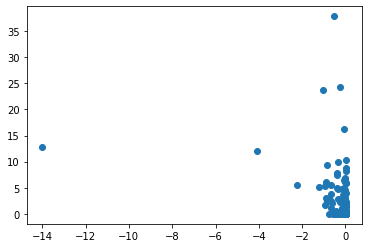

In [5]:
plt.scatter(Arctic_discharge_fluxes_with_area_export['terminus_gt_change_per_year_late'],Arctic_discharge_fluxes_with_area_export['2010_2020_mean_flux_gt'])

In [9]:
h5py.file('/Users/willkochtitzky/Projects/Greenland_Calving/King_data/individual_glaciers/079_jakobshavn.h5',"r")

AttributeError: module 'h5py' has no attribute 'file'

In [16]:
filename = '/Users/willkochtitzky/Projects/Greenland_Calving/King_data/individual_glaciers/079_jakobshavn.h5'

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data1 = list(f[a_group_key])

Keys: <KeysViewHDF5 ['discharge', 'front_position', 'ice_thickness', 'lat', 'lon', 'velocity']>


In [17]:
data = h5py.File(filename, "r")

In [51]:
data['discharge'].keys()

<KeysViewHDF5 ['ice_discharge', 'ice_discharge_err', 'time']>

In [56]:
np.nanmean(data['discharge']['ice_discharge'][:])

40.665320481481245

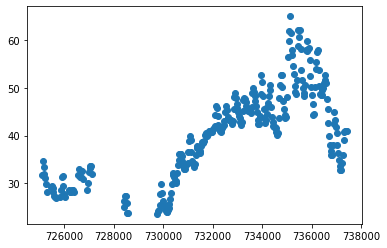

In [60]:
plt.scatter(data['discharge']['time'][:],data['discharge']['ice_discharge'][:])

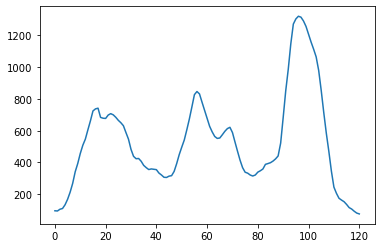

In [39]:
plt.plot(data['ice_thickness']['thickness'][50,:])

In [70]:
# data['velocity']['v']=data['velocity']['vx']**2+data['velocity']['vy']**2
data['velocity'].keys()

<KeysViewHDF5 ['dt', 'source', 'time', 'vx', 'vxe', 'vy', 'vye']>

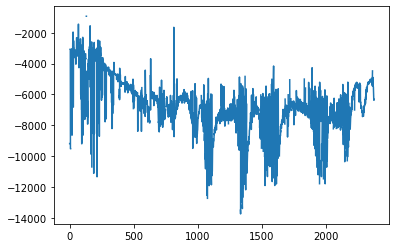

In [68]:
plt.plot(data['velocity']['vx'][100,:])

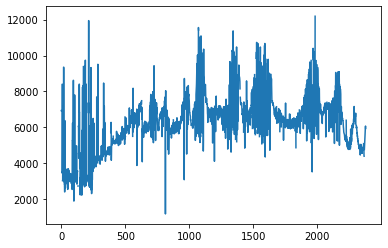

In [71]:
plt.plot(data['velocity']['vy'][100,:])

In [49]:
data['ice_thickness']['thickness'][1100,:].mean()

439.4152791519796

In [50]:
data['ice_thickness']['thickness'][1,:].mean()

547.0109474245181

In [3]:
#Create regions for Greenland
Arctic_discharge_fluxes_with_area_export = gpd.read_file('Greenland/Greenland_frontal_ablation_'+date_string+'.gpkg', driver="GPKG")
greenland_aois = gpd.read_file('/Users/willkochtitzky/Projects/Greenland_Calving/Greenland_regions.gpkg')
Arctic_discharge_fluxes_with_area_export = gpd.sjoin(Arctic_discharge_fluxes_with_area_export,greenland_aois)
Arctic_discharge_fluxes_with_area_export = Arctic_discharge_fluxes_with_area_export.drop(columns='index_right')
Arctic_discharge_fluxes_with_area_export['Greenland_region_name']=Arctic_discharge_fluxes_with_area_export['Greenland_region_name_right']
#need this for the figure to plot everything (since I copied this figure from the arctic frontal ablation paper)
Arctic_discharge_fluxes_with_area_export['Subregion_name']='all'

In [4]:
Arctic_discharge_fluxes_with_area_export.groupby('Greenland_region_name').sum()[['terminus_gt_change_per_year_late','2010_2020_mean_flux_gt','Frontal_ablation_2010_to_2020_gt_per_yr_mean']]

,terminus_gt_change_per_year_late,2010_2020_mean_flux_gt,Frontal_ablation_2010_to_2020_gt_per_yr_mean
Greenland_region_name,,,
E,-16.854443,38.389208,55.243543
N,-3.827605,21.753861,25.581463
SE,-4.890854,166.852276,171.741380
SW,-0.194075,12.793993,12.988001
W,-15.566287,184.975184,200.541121


In [5]:
Greenland_regional_totals = Arctic_discharge_fluxes_with_area_export.groupby('Greenland_region_name', as_index=False).agg({'2000_2010_mean_flux_gt':'sum','2010_2020_mean_flux_gt':'sum', 'Frontal_ablation_2000_to_2010_gt_per_yr_mean':'sum', 'Frontal_ablation_2000_to_2010_gt_per_yr_mean_err':'sum', 'Frontal_ablation_2010_to_2020_gt_per_yr_mean':'sum', 'Frontal_ablation_2010_to_2020_gt_per_yr_mean_err':'sum','easting':'mean','northing':'mean'})
Greenland_regional_totals = gpd.GeoDataFrame(Greenland_regional_totals, geometry=gpd.points_from_xy(Greenland_regional_totals['easting'],Greenland_regional_totals['northing']))
Greenland_regional_totals.drop(columns=['easting','northing'],inplace=True)
Greenland_regional_totals.reset_index(inplace=True,drop=True)
Greenland_regional_totals

,Greenland_region_name,2000_2010_mean_flux_gt,2010_2020_mean_flux_gt,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err,geometry
0,E,35.106943,38.389208,49.238117,3.149807,55.243543,2.250017,POINT (-636958.084 -1471419.213)
1,N,20.178589,21.753861,30.522404,2.364123,25.581463,2.542970,POINT (-577120.146 -571451.769)
2,SE,165.746697,166.852276,169.981512,NaN,171.741380,2.768449,POINT (-1691080.064 -2170550.323)
3,SW,12.369270,12.793993,12.631332,0.413390,12.988001,0.284193,POINT (-2183454.432 -1835003.053)
4,W,159.025439,184.975184,176.174286,4.798896,200.541121,3.157322,POINT (-1423662.621 -840539.601)


In [6]:
for region in Arctic_discharge_fluxes_with_area_export['Greenland_region_name'].unique():
    temp_data=Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Greenland_region_name']==region].reset_index(drop=True)
    root_sqaure_error=[]
    root_sqaure_error=np.sqrt(np.sum((temp_data['Frontal_ablation_2010_to_2020_gt_per_yr_mean_err'])**2))
#     print(region)
#     print('Frontal ablation total: ',sum(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Greenland_region_name']==region]['Frontal_ablation_2010_to_2020_gt_per_yr_mean']))
#     print('Sum of errors: ',sum(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Greenland_region_name']==region]['Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']))
#     print('Root sum square of errors: ',root_sqaure_error)
    Greenland_regional_totals.loc[Greenland_regional_totals['Greenland_region_name']==region,'Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']=root_sqaure_error
Greenland_regional_totals

,Greenland_region_name,2000_2010_mean_flux_gt,2010_2020_mean_flux_gt,Frontal_ablation_2000_to_2010_gt_per_yr_mean,Frontal_ablation_2000_to_2010_gt_per_yr_mean_err,Frontal_ablation_2010_to_2020_gt_per_yr_mean,Frontal_ablation_2010_to_2020_gt_per_yr_mean_err,geometry
0,E,35.106943,38.389208,49.238117,3.149807,55.243543,1.188561,POINT (-636958.084 -1471419.213)
1,N,20.178589,21.753861,30.522404,2.364123,25.581463,1.397305,POINT (-577120.146 -571451.769)
2,SE,165.746697,166.852276,169.981512,NaN,171.741380,0.399435,POINT (-1691080.064 -2170550.323)
3,SW,12.369270,12.793993,12.631332,0.413390,12.988001,0.081564,POINT (-2183454.432 -1835003.053)
4,W,159.025439,184.975184,176.174286,4.798896,200.541121,0.619421,POINT (-1423662.621 -840539.601)


In [7]:
Arctic_discharge_fluxes_with_area_export[['name','Frontal_ablation_2000_to_2010_gt_per_yr_mean']].sort_values('Frontal_ablation_2000_to_2010_gt_per_yr_mean',ascending=False)

,name,Frontal_ablation_2000_to_2010_gt_per_yr_mean
282,JAKOBSHAVN_ISBRAE,34.206397
394,HELHEIMGLETSCHER,26.214599
405,KANGERLUSSUAQ,24.894857
124,ZACHARIAE_ISSTROM,21.658108
408,KOGE_BUGT_C,16.108151
...,...,...
692,RGI60-05.13659,NaN
696,RGI60-05.13882,NaN
711,RGI60-05.13960,NaN
728,SE_NONAME9,NaN


In [8]:
Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].sum()

438.5476512743311

In [10]:
#FIGURE 1
rgi = gpd.read_file('/Users/willkochtitzky/Projects/Greenland_Calving/RGI_arctic_for_Greenland_plotting_custom_proj.gpkg')
for i in [0,1]:
    dataset = ['Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean']
    dataset_err = ['Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']
    dataset_discharge = ['2000_2010_mean_flux_gt','2010_2020_mean_flux_gt']
    date_period = ['2000_to_2010','2010_to_2020']

    Arctic_discharge_fluxes_with_area_export = Arctic_discharge_fluxes_with_area_export.sort_values(dataset[i],ascending=True)
    Arctic_discharge_fluxes_with_area_export.crs = {'init' :'epsg:3995'}
    
#build colormap    
    counter = 1
    marker_size_def = 30 #change marker size
    vmin_fill = 0.02
    vmax_fill = 30
    
    
    colors1 = plt.cm.Blues(np.linspace(0, 1, 73))
    colors2 = plt.cm.YlOrBr(np.linspace(0, 1, 547))
    colors2 = colors2[150:550]
    colors2[0:66] = colors1[7:73]

    # combine them and build a new colormap
#     colors = np.vstack((colors1, colors2))
    colors=colors2
    color_map = mcolors.LinearSegmentedColormap.from_list('color_map', colors)
#     color_map = 'plasma'


    
    #percent error
    per_err = (Arctic_discharge_fluxes_with_area_export[dataset_err[i]])/np.abs(Arctic_discharge_fluxes_with_area_export[dataset[i]])*100
    big_flux = Arctic_discharge_fluxes_with_area_export[dataset[i]]>vmin_fill
                                                                                                 
    #sort the subregions by longitude so that your plots go from west to east
    list_of_subregions = Arctic_discharge_fluxes_with_area_export.groupby('Subregion_name').mean()[['lon']].sort_values('lon').reset_index()['Subregion_name'].unique()
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor='silver',linewidth=0.2)
    glaciers = cfeature.NaturalEarthFeature(category='physical',name='glaciated_areas',scale='50m',facecolor='white')
    
    fig = plt.figure(figsize=(7,10))
#     for subregion_name in list_of_subregions:
    subregion_name = 'all'
    
    center_lat = Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['lat'].mean()
    center_lon = Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['lon'].mean()

    ax1 = plt.subplot(1,1,counter,projection=ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat))
    ax1.set_facecolor('#D5f4f5')
    ax1.add_feature(land_10m,zorder=1)
#     ax1.add_feature(glaciers,zorder=0)
#     ax1.add_feature(rgi)
    ax1.add_geometries(rgi.geometry, crs=ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat),facecolor='white',edgecolor='none',zorder=2) # for Lat/Lon data.
#     rgi.plot(color='white',ax=ax1,transform=ccrs.epsg('3995'),edgecolor='none')#,label='land terminating glacier',legend=True,zorder=1)
    Greenland_IS.plot(color='white',ax=ax1,transform=ccrs.epsg('3995'),edgecolor='none',label='land terminating glacier',legend=True,zorder=2)
    greenland_aois.plot(color='none',ax=ax1,transform=ccrs.epsg('3995'),edgecolor='gray',zorder=5)
#     ax1.autoscale(False)
    
    if i==0:
        im = Arctic_discharge_fluxes_with_area_export[(Arctic_discharge_fluxes_with_area_export[dataset[i]]<=vmin_fill)&(Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name)].plot(
            ax=ax1,
            markersize=marker_size_def*0.6,#make markers smaller
            facecolor='none',
            edgecolor='dimgray',
            marker='v',
            transform=ccrs.epsg('3995'),
            zorder=3)

    if i ==1:
        im = Arctic_discharge_fluxes_with_area_export[(Arctic_discharge_fluxes_with_area_export[dataset[i]]<=vmin_fill)&(Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name)&(Arctic_discharge_fluxes_with_area_export['Middle_satellite_id']!='nan')].plot(
            ax=ax1,
            markersize=marker_size_def*0.5,#make markers smaller
            facecolor='none',
            edgecolor='dimgray',
            marker='v',
            transform=ccrs.epsg('3995'),
            zorder=3)

#     num=[0.02,.05,0.1,0.15,0.2,0.25,0.3,0.5,0.8,1.2,1.8,2.5,100]
    num=[0.02,100]
#     for n in range(0,len(num)-1):
    n=0
    if i==0:
        plotting_group_flux=(Arctic_discharge_fluxes_with_area_export[dataset[i]]<=num[n+1])&(Arctic_discharge_fluxes_with_area_export[dataset[i]]>num[n])&(Arctic_discharge_fluxes_with_area_export['Middle_satellite_id']!='nan')
    if i==1:
        plotting_group_flux=(Arctic_discharge_fluxes_with_area_export[dataset[i]]<=num[n+1])&(Arctic_discharge_fluxes_with_area_export[dataset[i]]>num[n])&(Arctic_discharge_fluxes_with_area_export['Middle_satellite_id']!='nan')&(Arctic_discharge_fluxes_with_area_export['Late_satellite_id']!='nan')
    im_low = Arctic_discharge_fluxes_with_area_export[big_flux&plotting_group_flux&(per_err>=50)&(Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name)].plot(
        ax=ax1,
        markersize=marker_size_def*2.5, 
        column=Arctic_discharge_fluxes_with_area_export[big_flux&plotting_group_flux&(per_err>=50)&(Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name)][dataset[i]],
        vmin=vmin_fill, 
        vmax=vmax_fill,
        transform=ccrs.epsg('3995'),
        marker='s',
        cmap = color_map,
        zorder=4,
        linewidths=0.5, edgecolors='k')
    im_low = Arctic_discharge_fluxes_with_area_export[big_flux&plotting_group_flux&(per_err<50)&(Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name)].plot(
        ax=ax1,
        markersize=marker_size_def*2.5, 
        column=Arctic_discharge_fluxes_with_area_export[big_flux&plotting_group_flux&(per_err<50)&(Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name)][dataset[i]],
        vmin=vmin_fill, 
        vmax=vmax_fill,
        transform=ccrs.epsg('3995'),
        marker='o',
        cmap = color_map,
        zorder=4,
        linewidths=0.5, edgecolors='k')
 #Greenland

# plt.pie([534/19323,1-534/19323],colors=[num_color_1,num_color_2],radius=1,wedgeprops = { "edgecolor" : "k",'linewidth': pit_lw},startangle=90)
# circle1 = plt.Circle((0,0),minus_radius+0.1,fc='white')
# fig = plt.gcf()
# ax = fig.gca()
# ax.add_patch(circle1)
# plt.pie([29000/90000,1-29000/90000],colors=[area_color_1,area_color_2],wedgeprops = { "edgecolor" : "w",'linewidth': pit_lw},radius=minus_radius,startangle=90)

    color_map2 = 'viridis_r'
    marker_size_def2=5.5
    vmin_fill2 = 0
    vmax_fill2 = 60
    #fill in frontal ablation around the coast line
    pt_data_with_FA = gpd.read_file('frontal_ablation_surrounding_GRE_glaciers_sum'+date_period[i]+'_Greenland.gpkg',driver='GPKG')
    pt_data_with_FA.plot(column='Frontal_ablation_'+date_period[i]+'_gt_per_yr_mean',ax=ax1,cmap=color_map2,markersize=marker_size_def2,transform=ccrs.epsg('3995'),marker=(6,0,0),vmin=vmin_fill2,vmax=vmax_fill2,zorder=0)


    minus_radius=0.7
    area_color_1 = 'firebrick'
    area_color_2 = 'dodgerblue'
    pit_lw = 0
    counter=0
    
    regionsornot='regional_Greenland_'
    df_reg_early = pd.read_pickle('df_reg_early_'+regionsornot+'.pkl')
    df_reg_late = pd.read_pickle('df_reg_late_'+regionsornot+'.pkl')

    for GRE_region in Greenland_regional_totals['Greenland_region_name'].unique():
#         reg_discharge = float(Greenland_regional_totals[dataset_discharge[i]][Greenland_regional_totals['Greenland_region_name']==GRE_region])
#         reg_FA = float(Greenland_regional_totals[dataset[i]][Greenland_regional_totals['Greenland_region_name']==GRE_region])
#         reg_FA_err = float(Greenland_regional_totals[dataset_err[i]][Greenland_regional_totals['Greenland_region_name']==GRE_region])
        if i ==0:
            reg_FA = df_reg_early[df_reg_early['region']==GRE_region]['FA'][0]
            reg_FA_err = df_reg_early[df_reg_early['region']==GRE_region]['FA_err'][0]
            reg_discharge = df_reg_early[df_reg_early['region']==GRE_region]['Discharge'][0]
        if i ==1:
            reg_FA = df_reg_late[df_reg_late['region']==GRE_region]['FA'][0]
            reg_FA_err = df_reg_late[df_reg_late['region']==GRE_region]['FA_err'][0]
            reg_discharge = df_reg_late[df_reg_late['region']==GRE_region]['Discharge'][0]
        x_cord = float(Greenland_regional_totals[Greenland_regional_totals['Greenland_region_name']==GRE_region]['geometry'].x)
        y_cord = float(Greenland_regional_totals[Greenland_regional_totals['Greenland_region_name']==GRE_region]['geometry'].y)
        FA_portion = reg_FA/Greenland_regional_totals[dataset[i]].sum()
        
        if GRE_region == 'E':
            x_cord,y_cord=[0.76,0.72]
            x_cord_text,y_cord_text=[0.762,0.805]
        if GRE_region == 'W':
            x_cord,y_cord=[-0.08,0.21]
            x_cord_text,y_cord_text=[0.065,0.45]
        if GRE_region == 'SE':
#             x_cord,y_cord=[0.58,0.08]#with space for legend
            x_cord,y_cord=[0.45,-0.03]
            x_cord_text,y_cord_text=[0.59,0.12]
        if GRE_region == 'SW':
            x_cord,y_cord=[0.18,0.18]
            x_cord_text,y_cord_text=[0.065,0.18]
        if GRE_region == 'N':
            if i==0:
                x_cord_text,y_cord_text=[0.38,0.948]
                x_cord,y_cord=[0.39,0.895]
            if i==1:
                x_cord_text,y_cord_text=[0.38,0.944]
                x_cord,y_cord=[0.39,0.905]

        ax1.annotate(str(round(reg_FA,1))+'±\n'+str(round(reg_FA_err,1))+' Gt $a^{-1}$',zorder=100, xy=(x_cord_text,y_cord_text), xycoords='figure fraction',fontsize=12,color='black')
        fig.texts.append(ax1.texts.pop())
        a = plt.axes([x_cord, y_cord, FA_portion,FA_portion])#,ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat))
        plt.pie([reg_discharge/reg_FA,1-reg_discharge/reg_FA],colors=[area_color_1,area_color_2],wedgeprops = { "edgecolor" : "w",'linewidth': pit_lw},radius=minus_radius,startangle=90)
    
    text_font_size = 10
    ax1.annotate('Jakobshavn Isbræ',zorder=100, xy=(.325,.40), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Kangerlussuaq',zorder=100, xy=(.472,.373), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Helheim',zorder=100, xy=(.435,.285), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Zachariae Isstrøm',zorder=100, xy=(.492,.769), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Køge Bugt',zorder=100, xy=(.354,.243), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Hayes & Kjer',zorder=100, xy=(.27,.631), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Nioghalvfjerdsfjorden',zorder=100, xy=(.435,.782), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Rink',zorder=100, xy=(.312,.495), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Petermann',zorder=100, xy=(.336,.83), xycoords='figure fraction',fontsize=text_font_size,color='black')
    if i == 0:
        ax1.annotate('Kong Oscar',zorder=100, xy=(.255,.672), xycoords='figure fraction',fontsize=text_font_size,color='black')
    if i == 1:
        ax1.annotate('Upernavik North',zorder=100, xy=(.28,.554), xycoords='figure fraction',fontsize=text_font_size,color='black')
    
    fs=8
    ax1.annotate('60° N', xy=(0.8,0.078),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=8)
    ax1.annotate('70° N', xy=(0.847,0.469),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=18)
    ax1.annotate('80° N', xy=(0.76,0.843),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=30)
    
    ax1.annotate('50° W', xy=(0.201,0.03),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=79)
    ax1.annotate('40° W', xy=(0.476,0.015),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=90)
    ax1.annotate('30° W', xy=(0.758,0.03),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=-80)

    fig.texts.append(ax1.texts.pop())
    
    fig.subplots_adjust(hspace=0.1, wspace=0.01,top = .995, bottom = 0.005, right = .895, left = 0.005)

    gl = ax1.gridlines(linewidth=.25, color='gray', alpha=0.5)
    gl.xlocator = mticker.FixedLocator(range(-180,180, 10))
    gl.ylocator = mticker.FixedLocator(range(0,90, 5))
    ax1.set_aspect(aspect='equal',adjustable='datalim',anchor='N')#this works without plotting RGI
#     fig.tight_layout()
    counter = counter+1
    
    ax1.set_extent(
        [min(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].x-70000),
        max(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].x-100000),
        min(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].y+10000),
        max(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].y-70000)],
        crs = ccrs.epsg('3995'))
    
    ax1.set_extent([-2105000,-570000,-2000000,-900000,],crs = ccrs.epsg('3995'))
    ax1.set_aspect(aspect=1, adjustable='datalim',anchor='N')
    
    cax = fig.add_axes([0.90, 0.5, 0.03, 0.48]) # [left, bottom, width, height] 
    lpad=1
    # sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].min(), vmax=Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].max()))
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=vmin_fill, vmax=vmax_fill))
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.set_ylabel('Frontal ablation (Gt $a^{-1}$)',fontsize=12, labelpad=lpad)
    cbar.ax.tick_params(labelsize='medium')
    
    cax = fig.add_axes([0.90, 0.01, 0.03, 0.48]) # [left, bottom, width, height] 
    sm = plt.cm.ScalarMappable(cmap=color_map2, norm=plt.Normalize(vmin=vmin_fill2, vmax=vmax_fill2))
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.set_ylabel('Intensity index of frontal ablation (Gt $a^{-1}$)',fontsize=12, labelpad=lpad)
    cbar.ax.tick_params(labelsize='medium')

    #create legend
#     fig.patches.extend([plt.Rectangle((0.53,0.01),0.36,0.18,
#                   fill=True, color='white', alpha=0.9,
#                   transform=fig.transFigure, figure=fig)])
    
    if i == 0:
#         fig.suptitle('Arctic Frontal Ablation 2000-2010')
        fig.savefig('figures/2000to2010_Greenland_frontal_ablation_v21.jpg',format='jpg',dpi=600)
        plt.close()
    if i == 1:
#         fig.suptitle('Arctic Frontal Ablation 2010-2020')
        fig.savefig('figures/2010to2020_Greenland_frontal_ablation_v21.jpg',format='jpg',dpi=600)
        plt.close()
    print('done')
print('DONE')

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


done


/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


done
DONE


In [11]:
#FIGURE 2 - frontal ablation portions bigger than 0.5 Gt
Arctic_discharge_fluxes_with_area_export = gpd.read_file('Greenland/Greenland_frontal_ablation_'+date_string+'.gpkg', driver="GPKG")
Arctic_discharge_fluxes_with_area_export['Subregion_name']='all'
rgi = gpd.read_file('/Users/willkochtitzky/Projects/Greenland_Calving/RGI_arctic_for_Greenland_plotting_custom_proj.gpkg')
for i in [0,1]:
    dataset_discharge = ['2000_2010_mean_flux_gt','2010_2020_mean_flux_gt']
    dataset = ['Frontal_ablation_2000_to_2010_gt_per_yr_mean','Frontal_ablation_2010_to_2020_gt_per_yr_mean']
    dataset_err = ['Frontal_ablation_2000_to_2010_gt_per_yr_mean_err','Frontal_ablation_2010_to_2020_gt_per_yr_mean_err']
    time = ['early','late']
    
    Arctic_discharge_fluxes_with_area_export[time[i]]=100*Arctic_discharge_fluxes_with_area_export[dataset_discharge[i]]/Arctic_discharge_fluxes_with_area_export[dataset[i]]
    Arctic_discharge_fluxes_with_area_export = Arctic_discharge_fluxes_with_area_export.sort_values(dataset[i],ascending=False)
    Arctic_discharge_fluxes_with_area_export.crs = {'init' :'epsg:3995'}
    
#build colormap    
    counter = 1
    marker_size_def = 30 #change marker size
    vmin_fill = 0
    vmax_fill = 100
    vmin_fill = 0.1
    
    big_flux = Arctic_discharge_fluxes_with_area_export[dataset[i]]>vmin_fill
    
    colors1 = plt.cm.Blues(np.linspace(0, 1, 53))
    colors2 = plt.cm.YlOrBr(np.linspace(0, 1, 53))
    colors3 = plt.cm.YlOrBr(np.linspace(0, 1, 100))
#     colors2 = colors2[150:550]
    colors3[0:50] = colors1[1:51]
    colors3[50:100] = colors2[1:51]

    # combine them and build a new colormap
#     colors = np.vstack((colors1, colors2))
    colors=colors3
    color_map = mcolors.LinearSegmentedColormap.from_list('color_map', colors)
#     color_map = 'plasma'
                                                                           
    #sort the subregions by longitude so that your plots go from west to east
    list_of_subregions = Arctic_discharge_fluxes_with_area_export.groupby('Subregion_name').mean()[['lon']].sort_values('lon').reset_index()['Subregion_name'].unique()
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',edgecolor='black',facecolor='silver',linewidth=0.2)

    fig = plt.figure(figsize=(7,10))
#     for subregion_name in list_of_subregions:
    subregion_name = 'all'
    
    center_lat = Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['lat'].mean()
    center_lon = Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['lon'].mean()

    ax1 = plt.subplot(1,1,counter,projection=ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat))
    ax1.set_facecolor('#D5f4f5')
    ax1.add_feature(land_10m,zorder=0)
    ax1.add_geometries(rgi.geometry, crs=ccrs.Orthographic(central_longitude=center_lon, central_latitude=center_lat),facecolor='white',edgecolor='none',zorder=0) # for Lat/Lon data.
    Greenland_IS.plot(color='white',ax=ax1,transform=ccrs.epsg('3995'),edgecolor='none',label='land terminating glacier',legend=True,zorder=1)
    greenland_aois.plot(color='none',ax=ax1,transform=ccrs.epsg('3995'),edgecolor='gray')
    
    im_low = Arctic_discharge_fluxes_with_area_export[big_flux].plot(
        ax=ax1,
        markersize=Arctic_discharge_fluxes_with_area_export[big_flux][dataset[i]]*15,#marker_size_def*2.5, 
        column=Arctic_discharge_fluxes_with_area_export[big_flux][time[i]],
        vmin=vmin_fill, 
        vmax=vmax_fill,
        transform=ccrs.epsg('3995'),
        marker='o',
        cmap = color_map,
        zorder=4,
        linewidths=0.5, edgecolors='k')
    horz_shift = -0.01
    text_font_size = 10
    ax1.annotate('Jakobshavn Isbræ',zorder=100, xy=(.338,.393), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Kangerlussuaq',zorder=100, xy=(.475,.365), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Helheim',zorder=100, xy=(.435,.272), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Zachariae Isstrøm',zorder=100, xy=(.50,.776), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Køge Bugt',zorder=100, xy=(.355,.225), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Hayes & Kjer',zorder=100, xy=(.283+horz_shift,.633), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Nioghalvfjerdsfjorden',zorder=100, xy=(.452,.791), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Rink',zorder=100, xy=(.328+horz_shift,.494), xycoords='figure fraction',fontsize=text_font_size,color='black')
    ax1.annotate('Petermann',zorder=100, xy=(.35+horz_shift,.841), xycoords='figure fraction',fontsize=text_font_size,color='black')
    if i == 0:
        ax1.annotate('Kong Oscar',zorder=100, xy=(.255,.675), xycoords='figure fraction',fontsize=text_font_size,color='black')
    if i == 1:
        ax1.annotate('Upernavik North',zorder=100, xy=(.28,.555), xycoords='figure fraction',fontsize=text_font_size,color='black')
    
    fs=8
    ax1.annotate('60° N', xy=(0.82,0.052),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=8)
    ax1.annotate('70° N', xy=(0.07,0.468),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=-18)
    ax1.annotate('80° N', xy=(0.78,0.857),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=35)
    
    ax1.annotate('50° W', xy=(0.209,0.055),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=79)
    ax1.annotate('40° W', xy=(0.486,0.035),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=90)
    ax1.annotate('30° W', xy=(0.77,0.049),xycoords='figure fraction',fontsize=fs,zorder=5,color='black',rotation=-85)
    
    fig.texts.append(ax1.texts.pop())
    
    fig.subplots_adjust(hspace=0.1, wspace=0.01,top = .995, bottom = 0.005, right = .875, left = 0.005)

    gl = ax1.gridlines(linewidth=.25, color='gray', alpha=0.5)
    gl.xlocator = mticker.FixedLocator(range(-180,180, 10))
    gl.ylocator = mticker.FixedLocator(range(0,90, 5))
    ax1.set_aspect(aspect='equal',adjustable='datalim',anchor='N')#this works without plotting RGI
#     fig.tight_layout()
    counter = counter+1
    
    ax1.set_extent(
        [min(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].x-70000),
        max(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].x-100000),
        min(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].y+10000),
        max(Arctic_discharge_fluxes_with_area_export[Arctic_discharge_fluxes_with_area_export['Subregion_name']==subregion_name]['geometry'].y-70000)],
        crs = ccrs.epsg('3995'))

    cax = fig.add_axes([0.88, 0.25, 0.03, 0.5]) # [left, bottom, width, height] 
    # sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].min(), vmax=Arctic_discharge_fluxes_with_area_export['Frontal_ablation_2000_to_2010_gt_per_yr_mean'].max()))
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=vmin_fill, vmax=vmax_fill))
    cbar = fig.colorbar(sm, cax=cax)
    cbar.ax.set_ylabel('Discharge as portion of frontal ablation (%)',fontsize=12, labelpad=1)
    cbar.ax.tick_params(labelsize='medium')
    #create legend
#     fig.patches.extend([plt.Rectangle((0.53,0.01),0.36,0.18,
#                   fill=True, color='white', alpha=0.9,
#                   transform=fig.transFigure, figure=fig)])
    
    if i == 0:
#         fig.suptitle('Arctic Frontal Ablation 2000-2010')
        fig.savefig('figures/2000to2010_Greenland_frontal_ablation_portions_v10.jpg',format='jpg',dpi=600)
        plt.close()
    if i == 1:
#         fig.suptitle('Arctic Frontal Ablation 2010-2020')
        fig.savefig('figures/2010to2020_Greenland_frontal_ablation_portions_v10.jpg',format='jpg',dpi=600)
        plt.close()
    print('done')
print('DONE')

/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


done


/Users/willkochtitzky/opt/miniconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


done
DONE


In [20]:
pwd

'/Users/willkochtitzky/bin/Jupyter_notebooks/Arctic/Arctic_discharge'

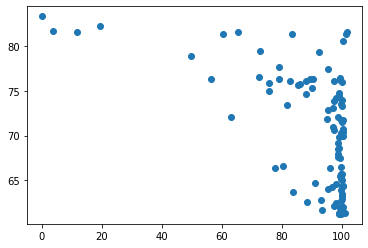

In [21]:
plt.scatter(Arctic_discharge_fluxes_with_area_export[big_flux]['discharge_percentage_late'],Arctic_discharge_fluxes_with_area_export[big_flux]['lat'])

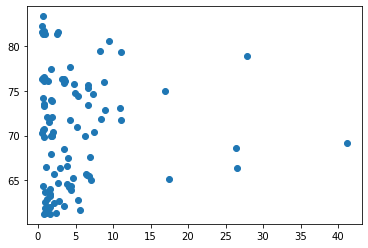

In [22]:
plt.scatter(Arctic_discharge_fluxes_with_area_export[big_flux]['Frontal_ablation_2010_to_2020_gt_per_yr_mean'],Arctic_discharge_fluxes_with_area_export[big_flux]['lat'])

In [25]:
Arctic_discharge_fluxes_with_area_export[big_flux]['Frontal_ablation_2010_to_2020_gt_per_yr_mean'].sum()

474.95605651489